In [2]:
#gets all this setup
import time
start_time = time.time()
from transformers import BertTokenizer
from pathlib import Path
import torch

from box import Box
import pandas as pd
import collections
import os
from tqdm import tqdm, trange
import sys
import random
import numpy as np
# import apex
from sklearn.model_selection import train_test_split

import datetime

import sys
sys.path.append('../')

from fast_bert.modeling import BertForMultiLabelSequenceClassification
from fast_bert.data_cls import BertDataBunch, InputExample, InputFeatures, MultiLabelTextProcessor, convert_examples_to_features
from fast_bert.learner_cls import BertLearner
# from fast_bert.metrics import accuracy_multilabel, accuracy_thresh, fbeta, roc_auc, accuracy
from fast_bert.metrics import *
import matplotlib.pyplot as plt

torch.cuda.empty_cache()

pd.set_option('display.max_colwidth', -1)
run_start_time = datetime.datetime.today().strftime('%Y-%m-%d_%H-%M-%S')



def create_model(column):
    
    if not os.path.exists('/scratch/da2734/twitter/mturk_mar6/log_{}/'.format(column)):
        os.makedirs('/scratch/da2734/twitter/mturk_mar6/log_{}/'.format(column))

    if not os.path.exists('/scratch/da2734/twitter/mturk_mar6/output_binary_{}'.format(column)):
        os.makedirs('/scratch/da2734/twitter/mturk_mar6/output_binary_{}'.format(column))

    LOG_PATH = Path('/scratch/da2734/twitter/mturk_mar6/log_{}/'.format(column))
    DATA_PATH = Path('/scratch/da2734/twitter/mturk_mar6/data_binary/')
    LABEL_PATH = Path('/scratch/da2734/twitter/mturk_mar6/data_binary/')
    OUTPUT_PATH = Path('/scratch/da2734/twitter/mturk_mar6/output_binary_{}'.format(column))
    FINETUNED_PATH = None

    args = Box({
        "run_text": "labor mturk ar 6 binary",
        "train_size": -1,
        "val_size": -1,
        "log_path": LOG_PATH,
        "full_data_dir": DATA_PATH,
        "data_dir": DATA_PATH,
        "task_name": "labor_market_classification",
        "no_cuda": False,
        #     "bert_model": BERT_PRETRAINED_PATH,
        "output_dir": OUTPUT_PATH,
        "max_seq_length": 512,
        "do_train": True,
        "do_eval": True,
        "do_lower_case": True,
        "train_batch_size": 8,
        "eval_batch_size": 16,
        "learning_rate": 5e-5,
        "num_train_epochs": 100,
        "warmup_proportion": 0.0,
        "no_cuda": False,
        "local_rank": -1,
        "seed": 42,
        "gradient_accumulation_steps": 1,
        "optimize_on_cpu": False,
        "fp16": False,
        "fp16_opt_level": "O1",
        "weight_decay": 0.0,
        "adam_epsilon": 1e-8,
        "max_grad_norm": 1.0,
        "max_steps": -1,
        "warmup_steps": 500,
        "logging_steps": 50,
        "eval_all_checkpoints": True,
        "overwrite_output_dir": True,
        "overwrite_cache": True,
        "seed": 42,
        "loss_scale": 128,
        "task_name": 'intent',
        "model_name": 'bert-base-uncased',
        "model_type": 'bert'
    })

    import logging

    logfile = str(LOG_PATH / 'log-{}-{}.txt'.format(run_start_time, args["run_text"]))

    logging.basicConfig(
        level=logging.INFO,
        format='%(asctime)s - %(levelname)s - %(name)s -   %(message)s',
        datefmt='%m/%d/%Y %H:%M:%S',
        handlers=[
            logging.FileHandler(logfile),
            logging.StreamHandler(sys.stdout)
        ])

    logger = logging.getLogger()

    logger.info(args)

    device = torch.device('cuda')
    if torch.cuda.device_count() > 1:
        args.multi_gpu = True
    else:
        args.multi_gpu = False

    label_cols = ['pos']

    databunch = BertDataBunch(
        args['data_dir'],
        LABEL_PATH,
        args.model_name,
        train_file='train_{}.csv'.format(column),
        val_file='val_{}.csv'.format(column),
        label_file='label_{}.csv'.format(column),
        # test_data='test.csv',
        text_col="text",  # this is the name of the column in the train file that containts the tweet text
        label_col=label_cols,
        batch_size_per_gpu=args['train_batch_size'],
        max_seq_length=args['max_seq_length'],
        multi_gpu=args.multi_gpu,
        multi_label=False,
        model_type=args.model_type)

    num_labels = len(databunch.labels)
    print('num_labels', num_labels)

    print('time taken to load all this stuff:', str(time.time() - start_time), 'seconds')

    # metrics defined: https://github.com/kaushaltrivedi/fast-bert/blob/d89e2aa01d948d6d3cdea7ad106bf5792fea7dfa/fast_bert/metrics.py
    metrics = []
    # metrics.append({'name': 'accuracy_thresh', 'function': accuracy_thresh})
    # metrics.append({'name': 'roc_auc', 'function': roc_auc})
    # metrics.append({'name': 'fbeta', 'function': fbeta})
    metrics.append({'name': 'accuracy', 'function': accuracy})
    # metrics.append({'name': 'accuracy_multilabel', 'function': accuracy_multilabel})

    learner = BertLearner.from_pretrained_model(
        databunch,
        pretrained_path='../mturk_mar6/output_binary_{}/model_out_2/'.format(column), 
        metrics=metrics,
        device=device,
        logger=logger,
        output_dir=args.output_dir,
        finetuned_wgts_path=FINETUNED_PATH,
        warmup_steps=args.warmup_steps,
        multi_gpu=args.multi_gpu,
        is_fp16=args.fp16,
        multi_label=False,
        logging_steps=0)
    
    return learner

/home/da2734/miniconda3/envs/worldbank/lib/python3.7/site-packages/ipykernel_launcher.py:33: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


is_unemployed
04/03/2020 14:28:05 - INFO - root -   {'run_text': 'labor mturk ar 6 binary', 'train_size': -1, 'val_size': -1, 'log_path': PosixPath('/scratch/da2734/twitter/mturk_mar6/log_is_unemployed'), 'full_data_dir': PosixPath('/scratch/da2734/twitter/mturk_mar6/data_binary'), 'data_dir': PosixPath('/scratch/da2734/twitter/mturk_mar6/data_binary'), 'task_name': 'intent', 'no_cuda': False, 'output_dir': PosixPath('/scratch/da2734/twitter/mturk_mar6/output_binary_is_unemployed'), 'max_seq_length': 512, 'do_train': True, 'do_eval': True, 'do_lower_case': True, 'train_batch_size': 8, 'eval_batch_size': 16, 'learning_rate': 5e-05, 'num_train_epochs': 100, 'warmup_proportion': 0.0, 'local_rank': -1, 'seed': 42, 'gradient_accumulation_steps': 1, 'optimize_on_cpu': False, 'fp16': False, 'fp16_opt_level': 'O1', 'weight_decay': 0.0, 'adam_epsilon': 1e-08, 'max_grad_norm': 1.0, 'max_steps': -1, 'warmup_steps': 500, 'logging_steps': 50, 'eval_all_checkpoints': True, 'overwrite_output_dir': Tr

job_search
04/03/2020 14:30:41 - INFO - root -   {'run_text': 'labor mturk ar 6 binary', 'train_size': -1, 'val_size': -1, 'log_path': PosixPath('/scratch/da2734/twitter/mturk_mar6/log_job_search'), 'full_data_dir': PosixPath('/scratch/da2734/twitter/mturk_mar6/data_binary'), 'data_dir': PosixPath('/scratch/da2734/twitter/mturk_mar6/data_binary'), 'task_name': 'intent', 'no_cuda': False, 'output_dir': PosixPath('/scratch/da2734/twitter/mturk_mar6/output_binary_job_search'), 'max_seq_length': 512, 'do_train': True, 'do_eval': True, 'do_lower_case': True, 'train_batch_size': 8, 'eval_batch_size': 16, 'learning_rate': 5e-05, 'num_train_epochs': 100, 'warmup_proportion': 0.0, 'local_rank': -1, 'seed': 42, 'gradient_accumulation_steps': 1, 'optimize_on_cpu': False, 'fp16': False, 'fp16_opt_level': 'O1', 'weight_decay': 0.0, 'adam_epsilon': 1e-08, 'max_grad_norm': 1.0, 'max_steps': -1, 'warmup_steps': 500, 'logging_steps': 50, 'eval_all_checkpoints': True, 'overwrite_output_dir': True, 'over

job_offer
04/03/2020 14:33:14 - INFO - root -   {'run_text': 'labor mturk ar 6 binary', 'train_size': -1, 'val_size': -1, 'log_path': PosixPath('/scratch/da2734/twitter/mturk_mar6/log_job_offer'), 'full_data_dir': PosixPath('/scratch/da2734/twitter/mturk_mar6/data_binary'), 'data_dir': PosixPath('/scratch/da2734/twitter/mturk_mar6/data_binary'), 'task_name': 'intent', 'no_cuda': False, 'output_dir': PosixPath('/scratch/da2734/twitter/mturk_mar6/output_binary_job_offer'), 'max_seq_length': 512, 'do_train': True, 'do_eval': True, 'do_lower_case': True, 'train_batch_size': 8, 'eval_batch_size': 16, 'learning_rate': 5e-05, 'num_train_epochs': 100, 'warmup_proportion': 0.0, 'local_rank': -1, 'seed': 42, 'gradient_accumulation_steps': 1, 'optimize_on_cpu': False, 'fp16': False, 'fp16_opt_level': 'O1', 'weight_decay': 0.0, 'adam_epsilon': 1e-08, 'max_grad_norm': 1.0, 'max_steps': -1, 'warmup_steps': 500, 'logging_steps': 50, 'eval_all_checkpoints': True, 'overwrite_output_dir': True, 'overwri

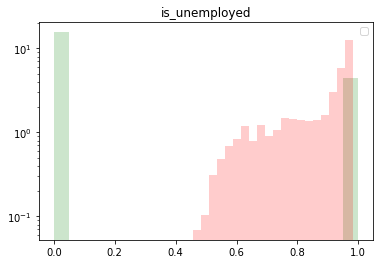

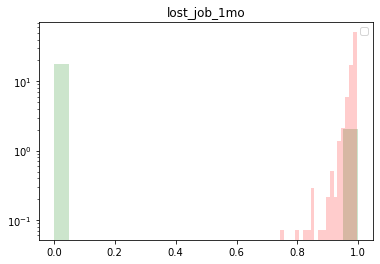

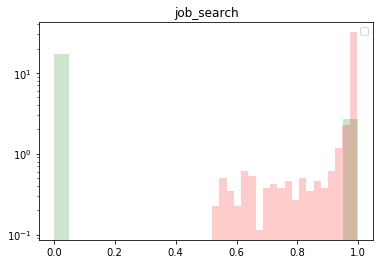

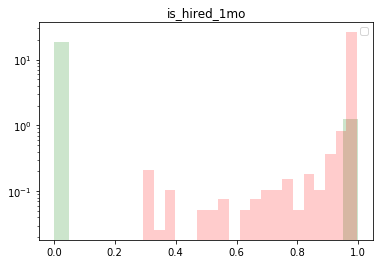

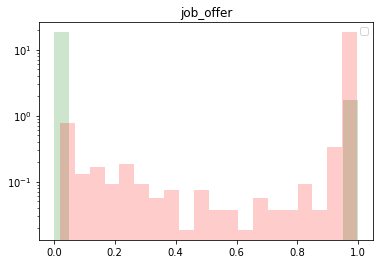

In [4]:
for column in ["is_unemployed", "lost_job_1mo", "job_search", "is_hired_1mo", "job_offer"]:
    print(column)
    start = time.time()
    trained_model = create_model(column)
    print('load model:', str(time.time() - start_time), 'seconds')
    
    start = time.time()
    val = pd.read_csv('/scratch/da2734/twitter/mturk_mar6/data_binary/val_{}.csv'.format(column))
    print(val.shape)
    # start_time = time.time()
    texts = val['text'].values.tolist()
#     print(len(texts))
    predictions = trained_model.predict_batch(texts)
    # predictions.head()
    print('inference:', str(time.time() - start_time), 'seconds on ', len(texts), 'tweets')

    prediction_df = pd.DataFrame(
    [dict(prediction) for prediction in predictions],
        index=val.id
        ).rename(columns={
        'pos':'pos_model',
        'neg':'neg_model',
    #     'is_hired_1mo':'is_hired_1mo_model',
    #     'lost_job_1mo':'lost_job_1mo_model',
    #     'job_offer"':'job_offer_model',
        }
    )

#     prediction_df.head()
        
    merged = prediction_df.merge(val, on='id')
    print(merged.head())
    
    fig = plt.figure()
    ax = plt.subplot(111)
    plt.hist(merged['pos'], bins=20, density = True, color = 'green', alpha = 0.2)
    plt.hist(merged['pos_model'], bins=20, density = True, color = 'red', alpha = 0.2)
    ax.set_yscale('log')

    # plt..yscale(value)
    plt.title(column)
    ax.legend()

    plt.savefig('/scratch/da2734/twitter/mturk_mar6/data_binary/plot_{}.png'.format(column))

    
#     break

is_unemployed
04/03/2020 14:48:20 - INFO - root -   {'run_text': 'labor mturk ar 6 binary', 'train_size': -1, 'val_size': -1, 'log_path': PosixPath('/scratch/da2734/twitter/mturk_mar6/log_is_unemployed'), 'full_data_dir': PosixPath('/scratch/da2734/twitter/mturk_mar6/data_binary'), 'data_dir': PosixPath('/scratch/da2734/twitter/mturk_mar6/data_binary'), 'task_name': 'intent', 'no_cuda': False, 'output_dir': PosixPath('/scratch/da2734/twitter/mturk_mar6/output_binary_is_unemployed'), 'max_seq_length': 512, 'do_train': True, 'do_eval': True, 'do_lower_case': True, 'train_batch_size': 8, 'eval_batch_size': 16, 'learning_rate': 5e-05, 'num_train_epochs': 100, 'warmup_proportion': 0.0, 'local_rank': -1, 'seed': 42, 'gradient_accumulation_steps': 1, 'optimize_on_cpu': False, 'fp16': False, 'fp16_opt_level': 'O1', 'weight_decay': 0.0, 'adam_epsilon': 1e-08, 'max_grad_norm': 1.0, 'max_steps': -1, 'warmup_steps': 500, 'logging_steps': 50, 'eval_all_checkpoints': True, 'overwrite_output_dir': Tr

job_search
04/03/2020 14:50:50 - INFO - root -   {'run_text': 'labor mturk ar 6 binary', 'train_size': -1, 'val_size': -1, 'log_path': PosixPath('/scratch/da2734/twitter/mturk_mar6/log_job_search'), 'full_data_dir': PosixPath('/scratch/da2734/twitter/mturk_mar6/data_binary'), 'data_dir': PosixPath('/scratch/da2734/twitter/mturk_mar6/data_binary'), 'task_name': 'intent', 'no_cuda': False, 'output_dir': PosixPath('/scratch/da2734/twitter/mturk_mar6/output_binary_job_search'), 'max_seq_length': 512, 'do_train': True, 'do_eval': True, 'do_lower_case': True, 'train_batch_size': 8, 'eval_batch_size': 16, 'learning_rate': 5e-05, 'num_train_epochs': 100, 'warmup_proportion': 0.0, 'local_rank': -1, 'seed': 42, 'gradient_accumulation_steps': 1, 'optimize_on_cpu': False, 'fp16': False, 'fp16_opt_level': 'O1', 'weight_decay': 0.0, 'adam_epsilon': 1e-08, 'max_grad_norm': 1.0, 'max_steps': -1, 'warmup_steps': 500, 'logging_steps': 50, 'eval_all_checkpoints': True, 'overwrite_output_dir': True, 'over

job_offer
04/03/2020 14:53:22 - INFO - root -   {'run_text': 'labor mturk ar 6 binary', 'train_size': -1, 'val_size': -1, 'log_path': PosixPath('/scratch/da2734/twitter/mturk_mar6/log_job_offer'), 'full_data_dir': PosixPath('/scratch/da2734/twitter/mturk_mar6/data_binary'), 'data_dir': PosixPath('/scratch/da2734/twitter/mturk_mar6/data_binary'), 'task_name': 'intent', 'no_cuda': False, 'output_dir': PosixPath('/scratch/da2734/twitter/mturk_mar6/output_binary_job_offer'), 'max_seq_length': 512, 'do_train': True, 'do_eval': True, 'do_lower_case': True, 'train_batch_size': 8, 'eval_batch_size': 16, 'learning_rate': 5e-05, 'num_train_epochs': 100, 'warmup_proportion': 0.0, 'local_rank': -1, 'seed': 42, 'gradient_accumulation_steps': 1, 'optimize_on_cpu': False, 'fp16': False, 'fp16_opt_level': 'O1', 'weight_decay': 0.0, 'adam_epsilon': 1e-08, 'max_grad_norm': 1.0, 'max_steps': -1, 'warmup_steps': 500, 'logging_steps': 50, 'eval_all_checkpoints': True, 'overwrite_output_dir': True, 'overwri

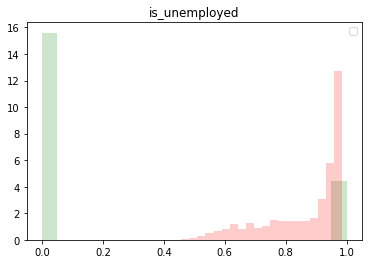

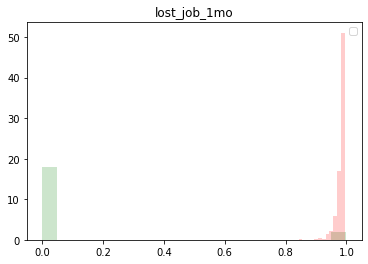

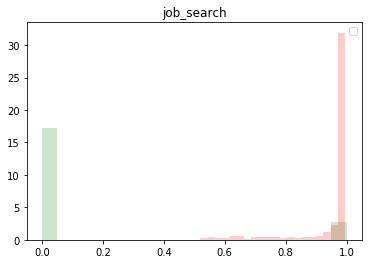

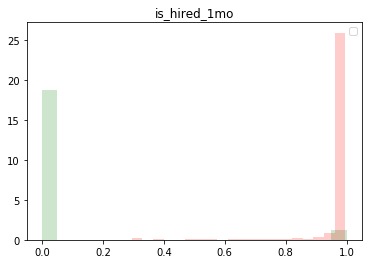

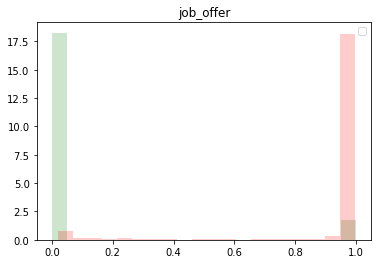

In [5]:
for column in ["is_unemployed", "lost_job_1mo", "job_search", "is_hired_1mo", "job_offer"]:
    print(column)
    start = time.time()
    trained_model = create_model(column)
    print('load model:', str(time.time() - start_time), 'seconds')
    
    start = time.time()
    val = pd.read_csv('/scratch/da2734/twitter/mturk_mar6/data_binary/val_{}.csv'.format(column))
    print(val.shape)
    # start_time = time.time()
    texts = val['text'].values.tolist()
#     print(len(texts))
    predictions = trained_model.predict_batch(texts)
    # predictions.head()
    print('inference:', str(time.time() - start_time), 'seconds on ', len(texts), 'tweets')

    prediction_df = pd.DataFrame(
    [dict(prediction) for prediction in predictions],
        index=val.id
        ).rename(columns={
        'pos':'pos_model',
        'neg':'neg_model',
    #     'is_hired_1mo':'is_hired_1mo_model',
    #     'lost_job_1mo':'lost_job_1mo_model',
    #     'job_offer"':'job_offer_model',
        }
    )

#     prediction_df.head()
        
    merged = prediction_df.merge(val, on='id')
    print(merged.head())
    
    fig = plt.figure()
    ax = plt.subplot(111)
    plt.hist(merged['pos'], bins=20, density = True, color = 'green', alpha = 0.2)
    plt.hist(merged['pos_model'], bins=20, density = True, color = 'red', alpha = 0.2)
#     ax.set_yscale('log')

    # plt..yscale(value)
    plt.title(column)
    ax.legend()

    plt.savefig('/scratch/da2734/twitter/mturk_mar6/data_binary/plot_{}.png'.format(column))

    
#     break